In [ ]:
import sys
import os
import shutil
import time
import importlib

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from random import randint
from types import SimpleNamespace

In [4]:
from utils import compressor
from utils import decompressor
from utils import image_utils
from utils import network_utils
from utils import compression_utils 
from utils import glob 
from utils import performance_utils
from utils import custom_lzma

In [5]:
# In caso di modifiche ai sorgenti 
importlib.reload(image_utils)
importlib.reload(network_utils)
importlib.reload(compression_utils)
importlib.reload(glob)

<module 'utils.glob' from 'C:\\Users\\thefo\\CompressioneDati\\utils\\glob.py'>

In [6]:
autoencoder = tf.keras.models.load_model('modello.h5')

In [7]:
encoder, decoder = network_utils.get_trained_encoder_decoder(autoencoder, n_layers=6)

### 1) Compression and decompression testing and time performances

In [8]:
error_correction_desidered_quality = 95 # 0 = Lowest quality, 100 = highest_quality (almost lossless compression)
path = "parrots.png"

In [9]:
#Compressor and decompressor time performances.
compression_code = compressor.compress(path, encoder, decoder, error_correction_desidered_quality)
decompressed_image = decompressor.decompress(compression_code, decoder)

Compressor STARTS
Image loaded. Elapsed: 0.015456662000000065
Image padded. Elapsed: 0.014162266999999673
Image separated into blocks. Elapsed: 4.729399999980899e-05
Image blocks compressed through network. Elapsed: 1.0196179529999991
Blocks recompressed through LZMA. Elapsed: 1.0509440659999996
Image decompressed. Elapsed: 0.19868863999999942
Proper treshold computed. Elapsed: 0.020798742000000203
Treshold is 0.0009278707206249238
Relevant errors computed. Elapsed: 0.04689946600000017
Relevant errors LZMA compressed. Elapsed: 4.949380304
Compressor ENDS. Total compressor computation time is 7.318460297

Decompressor STARTS
Blocks LZMA decompressed. Elapsed: 0.17699903900000002
Blocks decompressed through decoder network. Elapsed: 0.10950491200000023
Network decompressed image saved in predicted/network_decompression.png. Elapsed: 0.2367226819999999
Relevant errors decompressed through LZMA. Elapsed: 0.4836766380000004
Image error corrected. Elapsed: 0.8299947060000008
Error-corrected 

#### 2) Compression ratio 

In [10]:
#Compression ratio evaluation
rgb_image, alpha_channel = image_utils.load_image(path)
performance_utils.evaluate_compression_ratio(rgb_image, alpha_channel, compression_code)

size_rgb_image 4718592 shape rgb image (512, 768, 3)
type rgb_image <class 'numpy.float32'>

size_alpha_channel = 0 

size_compressed_blocks_lz 1688365
type compressed_blocks_lz <class 'bytes'>

size_important_errors 4297133
type important_errors_lz <class 'bytes'>

size_alpha_channel_lz = 0 

compression_ratio = original_size/compressed_size 
original_size = size_alpha_channel + size_rgb_image 
compressed_size = size_compressed_blocks_lz + size_important_errors_lz + size_alpha_channel_lz 


0.7883374115236527

#### 3) Autoencoder block compression/decompression error (mean and std)

In [11]:
#Autoencoder's compression/decompression error evaluation (mean and standard deviation)
error_informations = performance_utils.autoencoder_error_evaluation(rgb_image, compression_code, decoder , p=False)[2:6]
print ("mean error " + str(error_informations[0]))
print ("error std " + str(error_informations[1]))
print ("mean absolute error " + str(error_informations[2]))
print ("asolute error std " + str(error_informations[3]))

mean error 0.0064177862
error std 0.025000265
mean absolute error 0.015045037
asolute error std 0.020972557


#### 4) Autoencoder with error correction: PSNR

In [12]:
decoded_image = err_corrected_image = image_utils.load_image("predicted/decompression_error_corrected.png")[0]
decoded_image_rgb = decoded_image[:,:, :3]
performance_utils.get_psnr(rgb_image, decoded_image)

71.01930377662276

### 5) Lena, Parrots, Madrill: PSNR and compression ratio values with all possible error correction quality values

In [13]:
#PSNR amd compression_ratio evaluation with all possible error correction quality values 
image_paths = ["lena.png", "parrots.png", "mandrill.png"]
psnrs, compression_ratios = performance_utils.estimate_psnr_and_compr_ratio(image_paths, encoder, decoder)

PSNRs and compression ratios with error correction quality 1 estimated
PSNRs and compression ratios with error correction quality 2 estimated
PSNRs and compression ratios with error correction quality 3 estimated
PSNRs and compression ratios with error correction quality 4 estimated
PSNRs and compression ratios with error correction quality 5 estimated
PSNRs and compression ratios with error correction quality 6 estimated
PSNRs and compression ratios with error correction quality 7 estimated
PSNRs and compression ratios with error correction quality 8 estimated
PSNRs and compression ratios with error correction quality 9 estimated
PSNRs and compression ratios with error correction quality 10 estimated
PSNRs and compression ratios with error correction quality 11 estimated
PSNRs and compression ratios with error correction quality 12 estimated
PSNRs and compression ratios with error correction quality 13 estimated
PSNRs and compression ratios with error correction quality 14 estimated
P

### 5.b) Plot Compression Ratio compared to error correction quality

# 

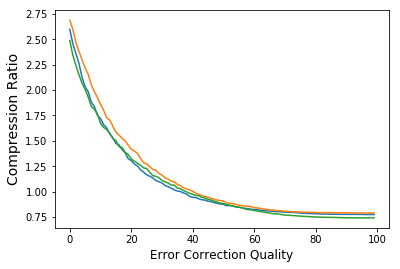

In [26]:
plt.xlabel('Error Correction Quality', fontsize=12)
plt.ylabel('Compression Ratio', fontsize=14)
plt.plot(np.asarray(compression_ratios[0])) # Blue curve for Lena
plt.plot(np.asarray(compression_ratios[1])) # Orange curve for Parrots
plt.plot(np.asarray(compression_ratios[2])) # Green curve for Mandrill

#### 5.c) Plot PSNR compared to error correction quality

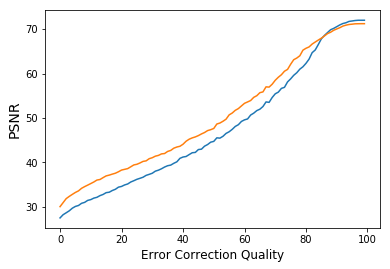

In [35]:
plt.xlabel('Error Correction Quality', fontsize=12)
plt.ylabel('PSNR', fontsize=14)
plt.plot(np.asarray(psnrs[0])) # Blue curve for Lena
plt.plot(np.asarray(psnrs[1])) # Orange curve for Parrots
plt.plot(np.asarray(psnrs[2])) # Green curve for Mandrill

#### 5.d) (Lena, Parrots, Mandrill) Plot PSNR compared to Compression ratio with same error correction quality value

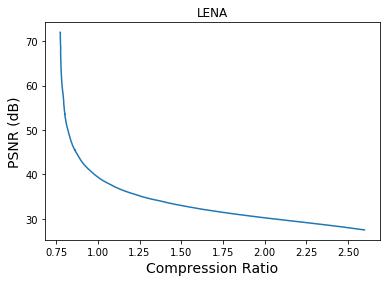

In [48]:
lena_comp_ratios = compression_ratios[0]
lena_psnrs = psnrs[0]
plt.title("LENA")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(lena_comp_ratios, lena_psnrs)

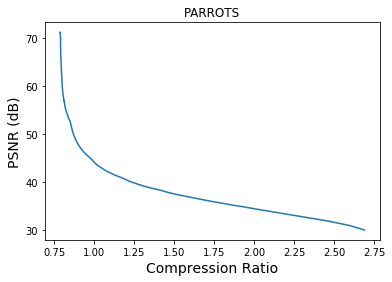

In [49]:
parrots_comp_ratios = compression_ratios[1]
parrots_psnrs = psnrs[1]
plt.title("PARROTS")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(parrots_comp_ratios, parrots_psnrs)

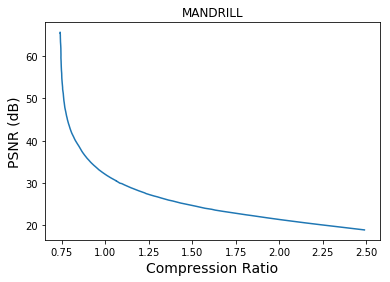

In [50]:
mandrill_comp_ratios = compression_ratios[2]
mandrill_psnrs = psnrs[2]
plt.title("MANDRILL")
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=14)
plt.plot(mandrill_comp_ratios, mandrill_psnrs)

### Load compression ratios and psnrs and vectors

In [47]:
psnrs = np.load("psnrs.npy")
compression_ratios = np.load("compression_ratios.npy")

### Get and train a new autoencoder instance

In [ ]:
conv_network = network_utils.get_autoencoder()
# Training takes 8 hours on NVIDIA GeForce 150MX
conv_network = network_utils.fit_network(conv_network)
encoder = network_utils.get_encoder()
encoder.set_weights(conv_network.get_weights()[0:6] )
decoder = network_utils.get_decoder()
decoder.set_weights(conv_network.get_weights()[6:] )